In [124]:
import numpy as np
import pandas as pd
from collections import defaultdict

from gensim import corpora, models
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline


import nltk
from nltk.corpus import stopwords


from META_helpers import *

reports_filtered = get_data(HighSensory=True, Handwritten=False,remove_stopwords=False,extended_stopwords=False)
data = reports_filtered.tolist()


2024-05-08 17:02:58,009 : DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.
/Users/rb666/projects/TopicModelling_META/META_TM/META_helpers.py:153: DtypeWarning: Columns (23,24,71,73,75,77,109,111,112,113,114,115,116,117,118,119,120,121,122,123,124,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,157,159,161,165,168,196,203,205) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATADIR)


Condition : "highsensory"
N=336 reports (condition : highsensory)
N=317 cleaned reports


### Text Cleaning and Prep


In [126]:


custom_stopwords = {'trevor', 'test','eg','devtest','hello','felt','like'}
stoplist = set(stopwords.words('english')).union(custom_stopwords)
print(stoplist)


# remove common words and tokenize
texts = [[word for word in report.split() if word not in stoplist]
         for report in data]

#print the number of unique tokens
dictionary = corpora.Dictionary(texts)
print(len(dictionary))


 # remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
         for text in texts]



#print the number of unique tokens
dictionary = corpora.Dictionary(texts)
print(len(dictionary))


# Add bigrams to docs (only ones that appear 5 times or more).
bigram = Phrases(texts, min_count=3)
for idx in range(len(texts)):
    for token in bigram[texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            texts[idx].append(token)
(len(texts))

#print the number of unique words
dictionary = corpora.Dictionary(texts)
print(len(dictionary))


# Filter out words that occur less than X documents, 
# or more than X% of the documents.
dictionary.filter_extremes(no_below=2)
print(len(dictionary))


# Create the corpus.  This is a Term Frequency 
# or Bag of Words representation.
corpus = [dictionary.doc2bow(text) for text in texts]

print(f'Number of unique tokens: {len(dictionary)}')
print(f'Number of documents: {len(corpus)}')


2024-05-08 17:03:04,812 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-05-08 17:03:04,815 : INFO : built Dictionary<1850 unique tokens: ['back', 'chaos', 'checked', 'die', 'imagine']...> from 317 documents (total 4334 corpus positions)
2024-05-08 17:03:04,816 : DEBUG : starting a new internal lifecycle event log for Dictionary
2024-05-08 17:03:04,816 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<1850 unique tokens: ['back', 'chaos', 'checked', 'die', 'imagine']...> from 317 documents (total 4334 corpus positions)", 'datetime': '2024-05-08T17:03:04.816361', 'gensim': '4.3.1', 'python': '3.11.3 (main, Apr 19 2023, 18:49:55) [Clang 14.0.6 ]', 'platform': 'macOS-14.4.1-arm64-arm-64bit', 'event': 'created'}
2024-05-08 17:03:04,817 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-05-08 17:03:04,820 : INFO : built Dictionary<654 unique tokens: ['back', 'chaos', 'die', 'imagine', 'intense']...> from 317 documents (total 3138 corpus positi

1850
654
660
644
Number of unique tokens: 644
Number of documents: 317


### Training the Topic Model

Points to consider : 
- Smaller chunks ensure that model updates are more frequent and can lead to a more stable convergence, albeit at the cost of longer training times


In [138]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)


NUM_TOPICS = 10 #number of topics LDA should try to identify in the corpus.
chunksize = 0.1*len(corpus) #chunksize of 10% of the number of documents
passes = 6 #number of times the model sees each document during training (can help improve accuracy)
iterations = 100 #maximum number of iterations over each document during a single pass
eval_every = 1
temp = dictionary[0]
id2word = dictionary.id2token


model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)

2024-05-08 17:23:02,634 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2024-05-08 17:23:02,635 : INFO : using serial LDA version on this node
2024-05-08 17:23:02,635 : INFO : running online (multi-pass) LDA training, 10 topics, 6 passes over the supplied corpus of 317 documents, updating model once every 31 documents, evaluating perplexity every 31 documents, iterating 100x with a convergence threshold of 0.001000
2024-05-08 17:23:02,636 : DEBUG : bound: at document #0
2024-05-08 17:23:02,644 : INFO : -9.622 per-word bound, 787.9 perplexity estimate based on a held-out corpus of 31 documents with 309 words
2024-05-08 17:23:02,644 : INFO : PROGRESS: pass 0, at document #31/317
2024-05-08 17:23:02,644 : DEBUG : performing inference on a chunk of 31 documents
2024-05-08 17:23:02,651 : DEBUG : 29/31 documents converged within 100 iterations
2024-05-08 17:23:02,652 : INFO : optimized alpha [0.086067826, 0.07624686, 0.07601452, 0.08409623, 0.

In [139]:
def compute_coherence_values(dictionary, corpus, texts, 
                             cohere, limit, start=2, step=1):

    coherence_values = []

    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         eval_every=eval_every,
                         random_state=77,)
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts, 
                                        dictionary=dictionary, 
                                        coherence=cohere)
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values


limit=10
start=3
step=1


coherence_values = compute_coherence_values(dictionary=dictionary, 
                                        corpus=corpus, 
                                        texts=texts, 
                                        cohere='c_v', 
                                        start=start, 
                                        limit=limit, 
                                        step=step)



2024-05-08 17:23:05,385 : INFO : using autotuned alpha, starting with [0.33333334, 0.33333334, 0.33333334]
2024-05-08 17:23:05,387 : INFO : using serial LDA version on this node
2024-05-08 17:23:05,396 : INFO : running online (multi-pass) LDA training, 3 topics, 6 passes over the supplied corpus of 317 documents, updating model once every 31 documents, evaluating perplexity every 31 documents, iterating 100x with a convergence threshold of 0.001000
2024-05-08 17:23:05,397 : DEBUG : bound: at document #0
2024-05-08 17:23:05,419 : INFO : -7.343 per-word bound, 162.3 perplexity estimate based on a held-out corpus of 31 documents with 309 words
2024-05-08 17:23:05,420 : INFO : PROGRESS: pass 0, at document #31/317
2024-05-08 17:23:05,421 : DEBUG : performing inference on a chunk of 31 documents
2024-05-08 17:23:05,435 : DEBUG : 28/31 documents converged within 100 iterations
2024-05-08 17:23:05,437 : INFO : optimized alpha [0.25585914, 0.2983087, 0.23480977]
2024-05-08 17:23:05,438 : DEBUG

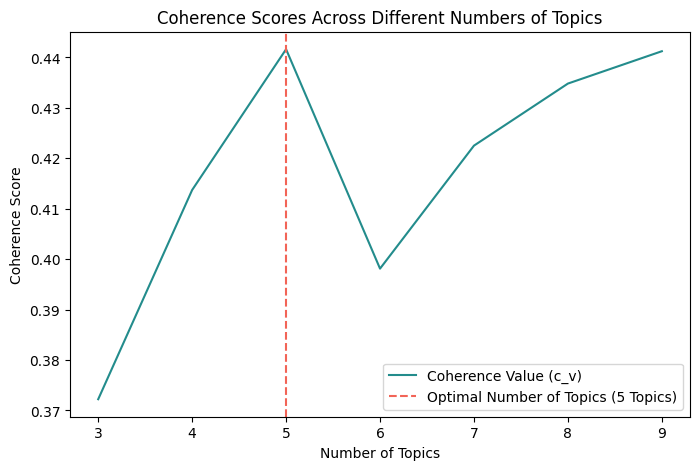

In [140]:
import matplotlib.pyplot as plt

# Assuming coherence_values and x are defined as in your example
plt.figure(figsize=(8, 5))
x = range(start, limit, step)

# Plot line
plt.plot(x, coherence_values, color='#238C8C', label='Coherence Value (c_v)')

# Add title and labels
plt.title("Coherence Scores Across Different Numbers of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")

# Highlight the maximum coherence value
max_index = np.argmax(coherence_values)
max_x = x[max_index]
max_y = coherence_values[max_index]
plt.axvline(max_x, color='#F26457', linestyle='--', label='Optimal Number of Topics ({} Topics)'.format(max_x))

# Add legend
plt.legend()

# Show the plot
plt.show()


### Final Run and Visualiztion of the Results


In [141]:
temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=100,
    num_topics=max_x,
    passes=max_x,
    eval_every=None)

pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary, sort_topics=True)

pyLDAvis.display(lda_viz)

2024-05-08 17:23:37,853 : INFO : using autotuned alpha, starting with [0.2, 0.2, 0.2, 0.2, 0.2]
2024-05-08 17:23:37,854 : INFO : using serial LDA version on this node
2024-05-08 17:23:37,854 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 317 documents, updating model once every 31 documents, evaluating perplexity every 0 documents, iterating 100x with a convergence threshold of 0.001000
2024-05-08 17:23:37,855 : INFO : PROGRESS: pass 0, at document #31/317
2024-05-08 17:23:37,855 : DEBUG : performing inference on a chunk of 31 documents
2024-05-08 17:23:37,863 : DEBUG : 30/31 documents converged within 100 iterations
2024-05-08 17:23:37,863 : INFO : optimized alpha [0.15430465, 0.1653808, 0.14565793, 0.15227638, 0.10775685]
2024-05-08 17:23:37,864 : DEBUG : updating topics
2024-05-08 17:23:37,864 : INFO : merging changes from 31 documents into a model of 317 documents
2024-05-08 17:23:37,865 : INFO : topic #0 (0.154): 0.035*"life" + 0.